In [1]:
import os

import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from utils.Dataset import IMDBDataset
from utils.Embedding import GloVeEmbedding
from models.SimpleModel import SimpleModel
from utils.training import train, evaluate 
from utils.plotting import plot_history

In [2]:
# Hyperparameters

seed = 123
torch.manual_seed(seed)

imdb_dir = './resources/aclImdb'
glove_dir = './resources/glove.6B'

seq_len = 100  # Max len of a seq
vocab_size = 10000  # Size of the tokenizer vocabulary
embedding_dim = 100  # Embedding layer dimension, one of {50, 100, 200, 300}

training_samples = 200  # Thanks to GloVe, a fewer samples are enough
validation_samples = 10000
batch_size = 32
learning_rate = 1e-4

epochs = 30
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# Prepare train/valid dataset

train_dir = os.path.join(imdb_dir, 'train')

dataset = IMDBDataset(train_dir, seq_len, vocab_size)
tokenizer = dataset.tokenizer  # Save the tokenizer for reuse
rest_samples = len(dataset) - training_samples - validation_samples
training, validation, _ = random_split(
    dataset, [training_samples, validation_samples, rest_samples])
train_dataloader = DataLoader(training, batch_size, True)
valid_dataloader = DataLoader(validation, batch_size, True)

print(f'Length of training: {len(training)}')
print(f'Length of validation: {len(validation)}')

Length of training: 200
Length of validation: 10000


In [4]:
# Model definition

glove_embedding = GloVeEmbedding(
    glove_dir, vocab_size, embedding_dim, 0, tokenizer.word_index)
model = SimpleModel(
    seq_len, vocab_size, embedding_dim, embedding=glove_embedding).to(device)
print(model)

SimpleModel(
  (embedding): GloVeEmbedding(
    (embedding_layer): Embedding(10001, 100, padding_idx=0)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=10000, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


Training done!


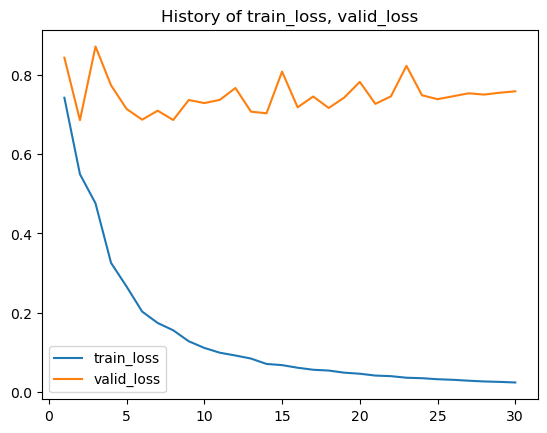

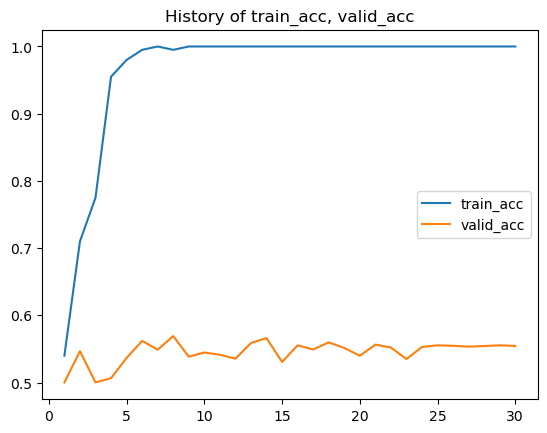

In [5]:
# Training and validation

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), learning_rate)
history = {'train_loss': [], 'train_acc': [],
           'valid_loss': [], 'valid_acc':[],
           'test_loss':[], 'test_acc':[]}

for _ in tqdm(range(epochs)):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, loss_fn, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)

plot_history(epochs, train_loss=history['train_loss'], valid_loss=history['valid_loss'])
plot_history(epochs, train_acc=history['train_acc'], valid_acc=history['valid_acc'])
print('Training done!')

In [6]:
# Test

test_dir = os.path.join(imdb_dir, 'test')
test_dataset = IMDBDataset(test_dir, seq_len, vocab_size, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size, True)
test_loss, test_acc = evaluate(test_dataloader, model, loss_fn, device)
print(f'{test_loss=}, {test_acc=}')


test_loss=0.762534205565977, test_acc=0.55732
